# Libs

In [369]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import seaborn
import cv2

from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

import os
import glob
import tqdm

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from io import BytesIO
from PIL import Image

In [371]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import load_model

In [63]:
%matplotlib inline

# DataGen

In [377]:
# DataGen replication with axes and lables separation

class GenerateDataset(Dataset):
    def __init__(self, num_samples, transform=None, tolerances=[80, 30], img_size=128, fig_size=5):
        self.num_samples = num_samples
        self.transform = transform
        self.tolerance = tolerances
        self.img_size = (img_size, img_size)
        self.fig_size = (fig_size, fig_size)

    def __len__(self):
        return self.num_samples

    def within_tolerance(self, img, color, tol):
        return np.all(np.abs(img - np.array(color) * 255) <= tol, axis=-1)

    def create_mask_with_squares(self, image, square_size=12):
        # Create a blank mask of the same size as the input image
        mask = np.zeros_like(image, dtype=np.uint8)

        # Find connected components (labels each connected group of pixels)
        print("Image property: ", image.shape, type(image), image.max(), image.min())
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

        # Calculate the half size of the square to center it on each tick/number
        half_size = square_size // 2

        # Loop through each centroid and draw a square
        for (x, y) in centroids[1:]:  # Skipping the first centroid (background)
            x, y = int(x), int(y)
            top_left = (max(0, x - half_size), max(0, y - half_size))
            bottom_right = (min(mask.shape[1], x + half_size), min(mask.shape[0], y + half_size))
            cv2.rectangle(mask, top_left, bottom_right, (255, 255, 255), thickness=-1)

        return mask

    def __getitem__(self, idx):

        x = np.linspace(-2, 2, 100)

        fig, ax = plt.subplots(figsize=self.fig_size)
        ax.set_xlim(-2, 2)
        ax.set_ylim(-10, 10)

        axes_color = [0.0, 0.0, 0.0]
        axes_labels = [1.0, 0.0, 0.0]
        axes_ticks = [0.0, 0.0, 1.0]

        N_OF_PLOTS = 2
        coefs, line_colors = {}, {}
        for i in range(N_OF_PLOTS):
            coefs[i] = np.random.uniform(-8, 8, 3)
            y = np.poly1d(coefs[i])
            line_colors[i] = np.random.uniform(0, 1, 3).round(2)
            ax.plot(x, y(x), color=line_colors[i])

        ax.tick_params(axis='x', colors='red')
        ax.tick_params(axis='y', colors='red')
        ax.tick_params(axis='x', which='both', color='blue')
        ax.tick_params(axis='y', which='both', color='blue')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)

        image = image[:, :, :3]

        axes_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        tick_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        label_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        plot_mask = np.zeros(image.shape[:2], dtype=np.uint8)

        axes_mask[self.within_tolerance(image, axes_color, self.tolerance[0])] = 1
        label_mask[self.within_tolerance(image, axes_labels, self.tolerance[0])] = 1
        label_mask = self.create_mask_with_squares(label_mask)
        for i in range(N_OF_PLOTS):
            plot_mask[self.within_tolerance(image, line_colors[i], self.tolerance[1])] = 1

        mask = np.stack((axes_mask, label_mask, plot_mask), axis=0)

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).long()

        image = F.interpolate(image.unsqueeze(0), size=self.img_size, mode='bilinear', align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).float(), size=self.img_size, mode='nearest').squeeze(0).long()

        return image, mask, coefs

def create_mask_with_squares(image, square_size=12):
    # Create a blank mask of the same size as the input image
    mask = np.zeros_like(image, dtype=np.uint8)

    # Find connected components (labels each connected group of pixels)
    print("Image property: ", image.shape, type(image), image.max(), image.min())
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

    # Calculate the half size of the square to center it on each tick/number
    half_size = square_size // 2

    # Loop through each centroid and draw a square
    for (x, y) in centroids[1:]:  # Skipping the first centroid (background)
        x, y = int(x), int(y)
        top_left = (max(0, x - half_size), max(0, y - half_size))
        bottom_right = (min(mask.shape[1], x + half_size), min(mask.shape[0], y + half_size))
        cv2.rectangle(mask, top_left, bottom_right, (255, 255, 255), thickness=-1)
    return mask

In [379]:
dataset = GenerateDataset(num_samples=4, img_size=300, fig_size=4, tolerances=[90, 20])

In [387]:
for img, mask, c in dataset:
    break

print("Shapes: ", img.shape, mask.shape)
print("Coefs: ", c)

Image property:  (400, 400) <class 'numpy.ndarray'> 1 0
Shapes:  torch.Size([3, 300, 300]) torch.Size([3, 300, 300])
Coefs:  {0: array([ 0.05302254, -0.0990632 , -2.32367862]), 1: array([-2.41189575,  0.65311962, -4.95811056])}


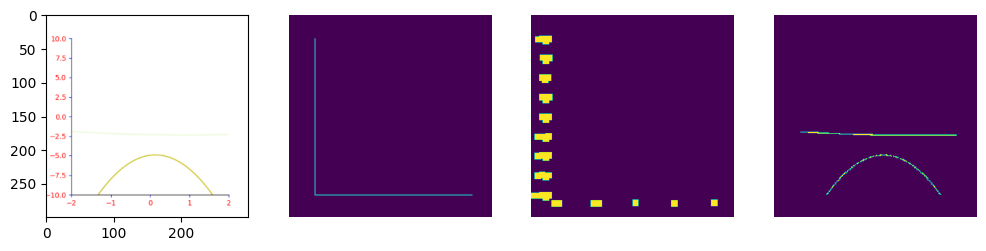

In [389]:
_, ax = plt.subplots(1, 4, figsize = (12, 8))
ax[0].imshow(np.transpose(img, (1,2,0)))
ax[1].imshow(mask[0])
ax[1].axis("off")
ax[2].imshow(mask[1])
ax[2].axis("off")
ax[3].imshow(mask[2])
ax[3].axis("off")
plt.show()

Image property:  (300, 300) <class 'numpy.ndarray'> 255 0


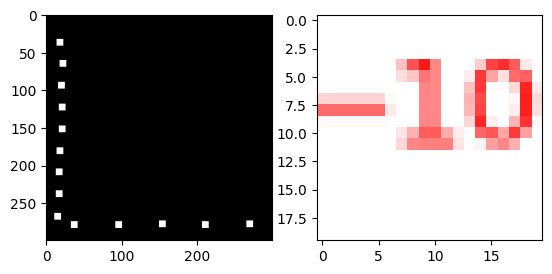

In [391]:
# based on mask need to fined each digit coordinates

ticks_img = mask[1].numpy()
ticks_img = np.array(ticks_img, dtype=np.uint8)
square = create_mask_with_squares(ticks_img, square_size=8)

# Display the mask
_, ax = plt.subplots(1, 2)
ax[0].imshow(square, cmap='gray')
w_s = [270, 90, 20]
w_s = [260, 0, 20]
ax[1].imshow(np.transpose(img, (1,2,0))[w_s[0]:w_s[0] + w_s[2],w_s[1]:w_s[1] + w_s[2]])
plt.show()

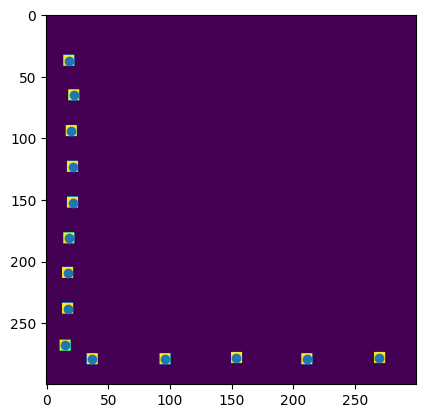

In [393]:
def estimate_cluster_num(binary_mask, eps=2, min_samples=1):
    y, x = np.where(binary_mask)
    coordinates = np.column_stack((x, y))
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)
    return len(unique_labels)

def get_cetners(img, n_of_cluster):
    y, x = np.where(img)
    kmeans = KMeans(n_clusters=n_of_cluster)
    kmeans.fit(np.column_stack((x, y)))
    return kmeans.cluster_centers_

n_samples = estimate_cluster_num(square, eps=2, min_samples=2)
centers = get_cetners(square, n_of_cluster = n_samples)
plt.imshow(square)
plt.scatter(centers[...,0], centers[...,1])

In [395]:
# align positions of detected labesl along lines
# make detection equidistant

def get_uniform_positions(centers):
    coords = []
    tol = 10  # adjust
    for slice in range(2):
        # Determine the minimum or maximum value along the current axis
        x_min_y_max = np.min(centers, axis=0) if slice == 0 else np.max(centers, axis=0)
        threshold = np.abs(centers[..., slice] - x_min_y_max[slice]) < tol
        
        # Select the positions close to x_min or y_max
        selected_positions = centers[threshold]
        
        # Align all positions along the mean of the current axis
        mean_value = np.mean(selected_positions, axis=0)
        selected_positions[..., slice] = int(mean_value[slice])
        
        # Sort the other axis values and create uniform spacing
        sorted_values = np.sort(selected_positions[..., 1 - slice])
        spacing = sorted_values - np.roll(sorted_values, 1, axis=0)
        spacing = int(np.mean(spacing[1:]))
        values_1 = [sorted_values[0] + spacing * i for i in range(len(sorted_values))]
        values_2 = [sorted_values[-1] - spacing * i for i in range(len(sorted_values))]
        uniform_values = (np.array(values_1) + np.array(values_2)[::-1]) // 2
        
        # Combine aligned positions with uniform distribution
        if slice == 0:
            coords.append(np.array([(int(mean_value[slice]), int(v)) for v in uniform_values]))
        else:
            coords.append(np.array([(int(v), int(mean_value[slice])) for v in uniform_values]))
    
    # Return both x and y coordinate arrays
    return coords[0], coords[1]

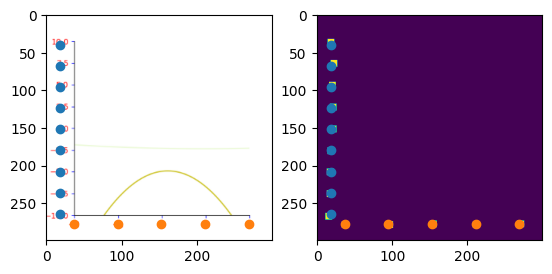

In [397]:
x_label, y_label = get_uniform_positions(centers)
n_samples = estimate_cluster_num(square, eps=2, min_samples=2)
centers = get_cetners(square, n_of_cluster = n_samples)
_, ax = plt.subplots(1, 2)
ax[0].imshow(np.transpose(img, (1, 2, 0)))
ax[0].scatter(x_label[...,0], x_label[...,1])
ax[0].scatter(y_label[...,0], y_label[...,1])
ax[1].imshow(square)
ax[1].scatter(x_label[...,0], x_label[...,1])
ax[1].scatter(y_label[...,0], y_label[...,1])

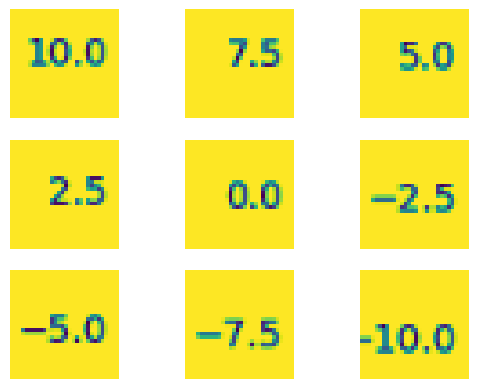

In [401]:
# crop lables from one of the axes for illustration

img_1 = np.copy(img)
img_1 = np.transpose(img_1, (1, 2, 0))
delta = 15 # to crop
_, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        frame = x_label[3*i + j]
        croped = img_1[frame[1]-delta:frame[1]+delta, frame[0]-delta:frame[0]+delta, :]
        croped = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
        ax[i][j].imshow(croped)
        ax[i][j].axis("off")

# LSTM

In [18]:
# Test of LSTM

# Create an LSTM layer
# input_size: Number of expected features in the input (e.g., embedding size or features per time step)
# hidden_size: Number of features in the hidden state
# num_layers: Number of recurrent layers (stacked LSTMs)
# batch_first: If True, the input and output tensors are expected to have shape (batch, seq, feature)
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)

# Generate a random input tensor
# Shape: (batch_size, sequence_length, input_size)
input_tensor = torch.randn(3, 5, 10)  # Example with batch_size=3, sequence_length=5, input_size=10

In [625]:
# Simple CRNN

class CRNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CRNN, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # output: (32, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: (32, 5, 5)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # output: (64, 5, 5)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # output: (64, 2, 2)
        )
        
        # Define the LSTM part
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(128 * 2, num_classes)  # num_classes = 10 for digits 0-9
        
    def forward(self, x):
        # Pass through CNN
        x = self.cnn(x)  # output: (batch_size, 64, 2, 2)
        
        # Reshape to (batch_size, sequence_length, features)
        x = x.view(x.size(0), 4, 64)  # output: (batch_size, 4, 64)
        
        # Pass through RNN
        x, _ = self.rnn(x)  # output: (batch_size, 4, 256)

        # Use only the last output of LSTM for classification
        x = x[:, -1, :]  # output: (batch_size, 256)

        # Pass through fully connected layer (apply to each sequence element)
        x = self.fc(x)  # output: (batch_size, 4, num_classes)
        
        # Apply softmax to get probabilities
        x = F.log_softmax(x, dim=2)  # output: (batch_size, 4, num_classes)
        
        return x

# Example usage
model = CRNN(num_classes=10)
input_image = torch.rand(1, 1, 10, 10)  # Batch size of 1, 1 channel (grayscale), 10x10 image
output = model(input_image)

# The output will be a tensor of shape (batch_size, sequence_length, num_classes)
print(output.shape)

torch.Size([1, 10]) tensor([[-2.2502, -2.3605, -2.3673, -2.2873, -2.2659, -2.3118, -2.2435, -2.2580,
         -2.3473, -2.3447]], grad_fn=<LogSoftmaxBackward0>)


In [20]:
# Final number extraction

# Simulated output tensor for a number "42"
# Shape: (batch_size, 4, 10), with batch_size = 1 for simplicity
output = torch.tensor([
    [
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],  # Low confidence for any digit
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],  # Low confidence for any digit
        [0.0, 0.1, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # High confidence for digit 4
        [0.1, 0.0, 0.0, 0.0, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0],  # High confidence for digit 2
    ]
])

# Extract predicted digits
predicted_digits = torch.argmax(output, dim=2)  # Shape: (batch_size, 4)
print("Predicted Digits:", predicted_digits)

# Convert to a number (assuming the output should be concatenated)
numbers = [int(''.join(map(str, digits.tolist()))) for digits in predicted_digits]
print("Interpreted Number:", numbers)

Predicted Digits: tensor([[0, 0, 2, 4]])
Interpreted Number: [24]


# GenerateNumbers

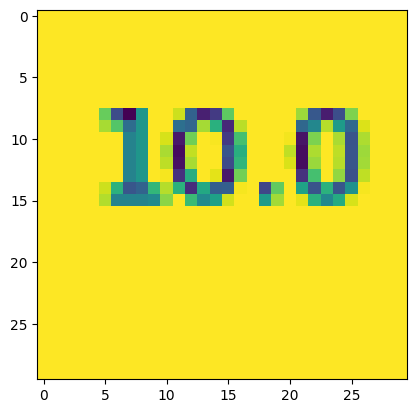

In [408]:
# just an example croped from an axis
# it will used to calibrate generated images

frame = x_label[0]
croped = img_1[frame[1]-delta:frame[1]+delta, frame[0]-delta:frame[0]+delta, :]
croped = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
plt.imshow(croped)

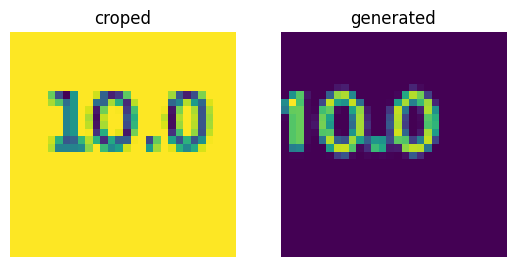

In [410]:
# trying to reproduce using putText
# howevere the font does not match

image = np.zeros((30, 30), dtype=np.uint8)
cv2.putText(image, '10.0', (-2, 15),
            cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
            0.32, 255, 1, cv2.LINE_AA)

_, ax = plt.subplots(1, 2)

ax[0].imshow(croped)
ax[0].axis("off")
ax[0].set_title("croped")

ax[1].imshow(image)
ax[1].axis("off")
ax[1].set_title("generated")

plt.show()

In [414]:
# reproducing using matplotlib
# the fotn match better

def _create_img(num, x_pos, y_pos, font_size):
    # Create a figure and axis to generate the image
    fig, ax = plt.subplots(figsize=(2 , 2), dpi=30)
    ax.text(x_pos, y_pos, f'{num:.1f}', fontsize=font_size, ha='center', va='center')
    ax.axis('off')

    # Save the plot to a buffer
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    plt.close(fig)

    # Convert the buffer to an image
    img = Image.open(buf)
    img = img.convert('L')  # Convert to grayscale
    img = np.array(img)
    
    # Resize and center crop to ensure consistent size
    img = cv2.resize(img, (30, 30), interpolation=cv2.INTER_AREA) / 255

    return img

def to_binary(img):
    img[img < .8] = 0
    img[img > .8] = 1.0
    return img

Text(0.5, 1.0, '-1.0 | 1.0')

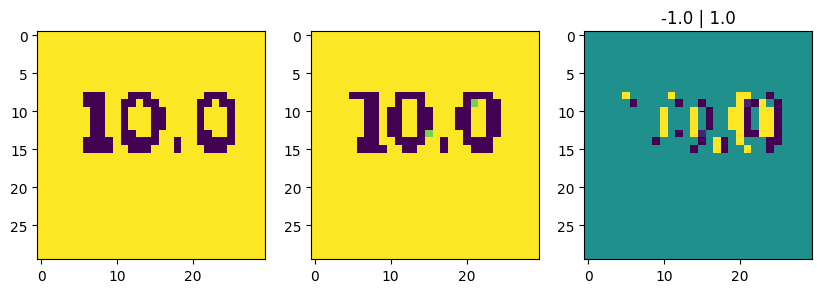

In [424]:
img = _create_img(10, 0.5, 0.57, 35)

_, ax = plt.subplots(1, 3, figsize = (10, 5))
ax[0].imshow(to_binary(croped))
ax[1].imshow(to_binary(img))
difference =  to_binary(croped) - to_binary(img)
ax[2].imshow(difference)
ax[2].set_title(f"{difference.min()} | {difference.max()}")

# DataLoader

In [ ]:
# dataloader

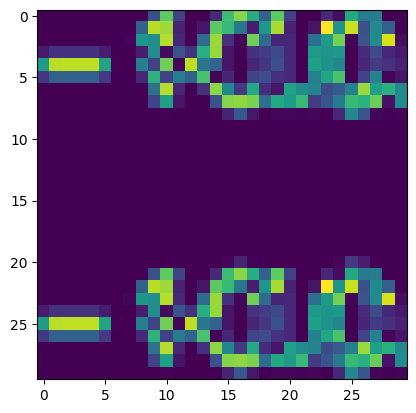

In [1912]:
def create_img(num, x, y):
    # x = [-2, 7]
    # y = [7, 28]
    image = np.zeros((30, 30), dtype=np.uint8)
    cv2.putText(image, f"{-float(num)}", (x, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.32, 255, 1, cv2.LINE_AA)
    return image

image = create_img(10, 7, 28)
plt.imshow(image)
image += create_img(10, -2, 28)
plt.imshow(image)
image += create_img(10, 7, 7)
plt.imshow(image)
image += create_img(10, -2, 7 )
plt.imshow(image)
plt.show()

In [677]:
# using cv2.putText()

# class GenerateDataset(Dataset):
#     def __init__(self, num_samples):
#         self.num_samples = num_samples
#         self.font_list = [cv2.FONT_HERSHEY_SIMPLEX]

#     def __len__(self):
#         return self.num_samples

#     def _create_img(self, num, x_bound, y_bound, s, font_n):
#         image = np.zeros((30, 30), dtype=np.uint8)
#         cv2.putText(image, f"{float(num)}", (x_bound, y_bound),
#                     self.font_list[font_n],
#                     s * 0.01, 255, 1, cv2.LINE_AA)
#         return image

#     def __getitem__(self, idx):
#         num = np.random.randint(0, 99)
#         fraction = np.random.choice([0.0, 0.5])
#         num += fraction
#         x_b = np.random.randint(-1, 7)
#         y_b = np.random.randint(8, 28)
#         s = np.random.randint(28, 42)
#         font = np.random.randint(0, len(self.font_list))
#         img = self._create_img(num, x_b, y_b, s, font)
#         img = np.expand_dims(img, axis=0)
#         img[img > 100] = 255
#         img[img < 100] = 0
#         noise = np.random.normal(0, 0.3, img.shape).astype(np.uint8)
#         img = cv2.add(img, noise)
#         return torch.tensor(img, dtype = torch.float32), torch.tensor([int(num // 10), int(num%10)])

class GenerateDataset(Dataset):

    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def _create_img(self, num, x_pos, y_pos, font_size):
        # Create a figure and axis to generate the image
        fig, ax = plt.subplots(figsize=(2 , 2), dpi=30)
        ax.text(x_pos, y_pos, f'{num:.1f}', fontsize=font_size, ha='center', va='center')
        ax.axis('off')
    
        # Save the plot to a buffer
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        plt.close(fig)
    
        # Convert the buffer to an image
        img = Image.open(buf)
        img = img.convert('L')  # Convert to grayscale
        img = np.array(img)
        
        # Resize and center crop to ensure consistent size
        img = cv2.resize(img, (30, 30), interpolation=cv2.INTER_AREA) / 255
    
        return img

    def to_binary(self, img, bound: float=0.8):
        img[img < bound] = 0
        img[img > bound] = 1.0
        return img

    def __getitem__(self, idx):
        # Generate a random number with either .0 or .5
        num = np.random.randint(0, 99)
        fraction = np.random.choice([0.0, 0.5])
        num += fraction

        # Create the image using Matplotlib
        f_size = np.random.randint(33, 38)
        x_pos = np.random.uniform(0.4, 0.7)
        y_pos = np.random.uniform(0.4, 0.7)
        img = self._create_img(num, x_pos, y_pos, font_size=f_size)

        # Expand dimensions to match the required input format
        img = np.expand_dims(img, axis=0)
        b = np.random.uniform(0.7, 0.9)
        img = self.to_binary(img, b)

        # Create the label
        #label = [int(num // 10), int(num % 10), int(5 if fraction == 0.5 else 0)]
        label = [int(num // 10), int(num % 10)]

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label)

def create_dataloader(num_samples: int = 32,
                      batch_size: int = 32,
                      shuffle: bool = False):
    dataset = GenerateDataset(num_samples=num_samples)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)    

In [679]:
data_loader = create_dataloader(num_samples = 32, shuffle=True)

torch.Size([32, 1, 30, 30])


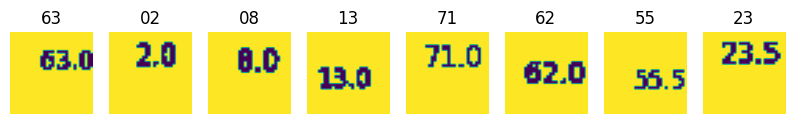

In [681]:
for img, num in data_loader:
    break
print(img.shape)
_, ax = plt.subplots(1, 8, figsize = (10, 5))
for n in range(8):
    ax[n].imshow(img[n][0])
    ax[n].set_title(f"{num[n][0]}{num[n][1]}")
    ax[n].axis("off")

In [697]:
number_dict = {"train": 2600, "validation": 256, "test": 32}

mode = "test"

num_img = number_dict[mode]
dataset = GenerateDataset(num_samples=num_img)
df = {}
for i, (img, lable) in enumerate(dataset):
    df[i] = lable.numpy()
    np.save(f"./data/numbers/{mode}/{i}.npy", img[0].numpy())
    if i == num_img:
        break
df = pd.DataFrame(df).T
df.to_csv(f"./data/numbers/{mode}/labels.csv")

In [592]:
class NumberDataset(Dataset):

    def __init__(self, mode: str = "train", num_samples=10, transform=None, img_size: int = 30):
        super(Dataset, self).__init__()
        self.num_samples = num_samples
        self.transform = transform
        self.img_size = (img_size, img_size)
        self.image_paths = f"./data/numbers/{mode}/"
        self.df = pd.read_csv(self.image_paths + "labels.csv")

    def __len__(self):
        return self.num_samples

    def extract_number(self, filename):
        base = os.path.basename(filename)
        number = os.path.splitext(base)[0]
        return int(number)

    def __getitem__(self, idx):
        img = np.load(self.image_paths + f"{idx}.npy")
        img = np.expand_dims(img, axis=0)
        label = self.df.iloc[idx]
        label = torch.tensor([label["0"], label["1"]])
        return img, label

def create_dataloader(num_samples: int = 32,
                      batch_size: int = 32,
                      shuffle: bool = False):
    dataset = NumberDataset(num_samples=num_samples)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)   

Text(0.5, 1.0, '1 3')

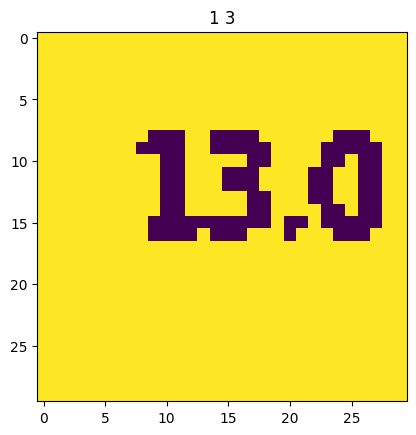

In [598]:
i = 0
for img, label in NumberDataset():
    i +=1 
    if i == 6:
        break
plt.imshow(img[0])
plt.title(f"{label[0]} {label[1]}")

# Model

In [2599]:
# model

In [684]:
# Simple CRNN

class CRNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CRNN, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # output: (32, 30, 30)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # output: (64, 15, 15)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # output: (64, 15, 15)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # output: (64, 7, 7)
        )
        
        # Define the LSTM part
        self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(128 * 2, num_classes)  # num_classes = 10 for digits 0-9
        
    def forward(self, x):
        # Pass through CNN
        x = self.cnn(x)  # output: (batch_size, 64, 7, 7)

        # Reshape to (batch_size, sequence_length, features)
        x = x.view(x.size(0), 49, 64)  # output: (batch_size, 4, 64)
        
        # Pass through RNN
        x, _ = self.rnn(x)  # output: (batch_size, 4, 256)

        # Use only the last two outputs of LSTM for classification
        x = x[:, -2:, :]  # output: (batch_size, 2, 256)

        # Pass through fully connected layer (apply to each sequence element)
        x = self.fc(x)  # output: (batch_size, 2, num_classes)
        
        # Apply log softmax to get probabilities
        x = F.log_softmax(x, dim=2)  # output: (batch_size, 2, num_classes)
        
        return x

# Example usage
num_classes = 10
crnn_model = CRNN(num_classes=10)
input_image = torch.rand(1, 1, 30, 30)  # Batch size of 1, 1 channel (grayscale), 10x10 image
output = crnn_model(input_image)

# The output will be a tensor of shape (batch_size, sequence_length, num_classes)
print(output.shape)

torch.Size([1, 2, 10])


# Train

In [603]:
# train

In [687]:
train_loader = create_dataloader(num_samples = 2600, batch_size=32, shuffle=True)
val_loader = create_dataloader(num_samples = 128, batch_size=16, shuffle=True)

In [689]:
optimizer = torch.optim.Adam(params=crnn_model.parameters(),
                             lr=3e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [691]:
DEVICE = "cpu"

class Trainer:

    def __init__(self, device: str = "mps") -> None:
        self.device = device
        pass

    def train_step(self,
                   model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer
                   ):
        model.train()
        train_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for X,y in dataloader:
            X = X.to(self.device)
            y = y.to(self.device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1, num_classes), y.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            y_pred = torch.argmax(y_pred, dim=2)
            correct_predictions += (y_pred == y).sum().item()
            total_predictions += y.numel()
        avg_train_loss = train_loss / len(dataloader)
        avg_train_accuracy = correct_predictions / total_predictions
        return avg_train_loss, avg_train_accuracy
    
    def val_step(self,
                 model: torch.nn.Module,
                 dataloader: torch.utils.data.DataLoader,
                 loss_fn: torch.nn.Module
                 ):
        model.eval()
        test_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.inference_mode():
            for X,y in dataloader:
                X = X.to(self.device)
                y = y.to(self.device)
                y_pred = model(X)
                loss = loss_fn(y_pred.view(-1, num_classes), y.view(-1))
                test_loss += loss.item()
                y_pred = torch.argmax(y_pred, dim=2)
                correct_predictions += (y_pred == y).sum().item()
                total_predictions += y.numel()
            avg_train_loss = test_loss / len(dataloader)
            avg_train_accuracy = correct_predictions / total_predictions
        return avg_train_loss, avg_train_accuracy

    def train(self,
              model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              val_dataloader: torch.utils.data.DataLoader,
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              epochs: int=100,
              output_freq: int=5):
        model = model.to(self.device)
        results = {"train_loss": [],
                "train_acc": [],
                "validation_loss": [],
                "validation_acc": []
                }
        for epoch in tqdm.tqdm(range(epochs)):
            train_loss, train_acc = self.train_step(model=model,
                                                    dataloader=train_dataloader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    )
            test_loss, test_acc = self.val_step(model=model,
                                                dataloader=val_dataloader,
                                                loss_fn=loss_fn,
                                                )
            if epoch%output_freq==0:
                print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"validation_loss: {test_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"validation_acc: {test_acc:.4f}"
                )
            results["train_loss"].append(train_loss)
            results["validation_loss"].append(test_loss)
            results["train_acc"].append(train_acc)
            results["validation_acc"].append(test_acc)
        return results

train_set = Trainer(device=DEVICE)

In [693]:
history = train_set.train(
    model=crnn_model,
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=51,
    output_freq=10
)

  2%|▏         | 1/51 [00:23<19:30, 23.41s/it]

Epoch: 1 | train_loss: 2.3038 | validation_loss: 2.3015 | train_acc: 0.1025 | validation_acc: 0.1016


 22%|██▏       | 11/51 [11:39<23:41, 35.54s/it]  

Epoch: 11 | train_loss: 1.9678 | validation_loss: 1.8965 | train_acc: 0.2319 | validation_acc: 0.2461


 33%|███▎      | 17/51 [15:49<31:39, 55.86s/it]


KeyboardInterrupt: 

<Figure size 60x60 with 0 Axes>

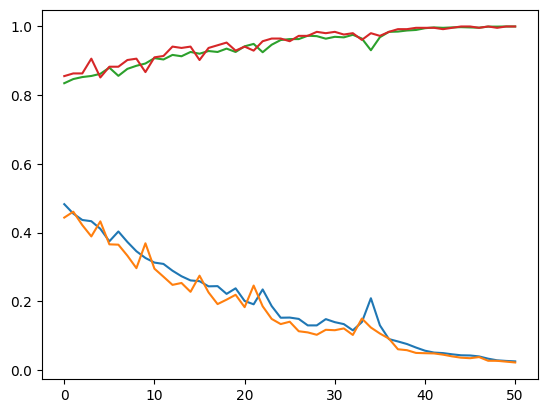

In [649]:
plt.plot(history["train_loss"])
plt.plot(history["validation_loss"])
plt.plot(history["train_acc"])
plt.plot(history["validation_acc"])

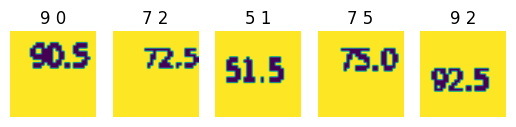

In [653]:
for img, num in train_loader:
    break

output = crnn_model(img)

predicted_digits = torch.argmax(output, dim=2)

y_pred = [tuple(digits.tolist()) for digits in predicted_digits]

_, ax = plt.subplots(1, 5)
for n in range(5):
    ax[n].imshow(img[n][0])
    ax[n].set_title(f"{y_pred[n][0]} {y_pred[n][1]}")
    ax[n].axis("off")

In [655]:
def test_predict(img):
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img = torch.tensor(img)
    output = crnn_model(img)
    predicted_digits = torch.argmax(output, dim=2)
    return predicted_digits

def to_binary(img, bound: float=0.8):
    img[img < bound] = 0
    img[img > bound] = 1.0
    return img

In [2628]:
def croped_prep(croped):
    # croped -= croped.min()
    # croped *= -1
    croped -= croped.min()
    croped[croped > 0.4] = 1
    croped[croped < 0.4] = 0
    croped *= 255
    return croped

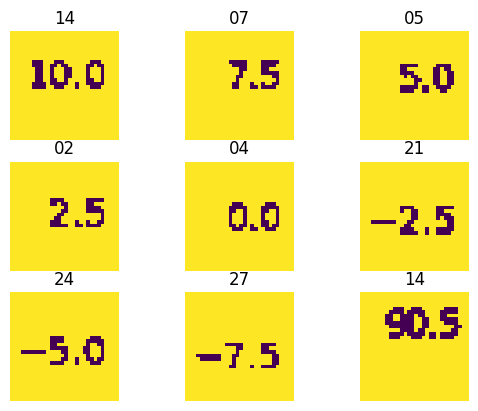

In [657]:
# img_1 = np.copy(img)
# img_1 = np.transpose(img_1, (1, 2, 0))
delta = 15
_, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        frame = x_label[3*i + j]
        croped = img_1[frame[1]-delta:frame[1]+delta, frame[0]-delta:frame[0]+delta, :]
        croped = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
        #croped = croped_prep(croped)
        croped = to_binary(croped)
        ax[i][j].imshow(croped)
        ax[i][j].axis("off")
        y_pred = test_predict(croped).numpy().reshape(2)
        ax[i][j].set_title(f"{y_pred[0]}{y_pred[1]}")
ax[i][j].imshow(img[0][0].numpy())

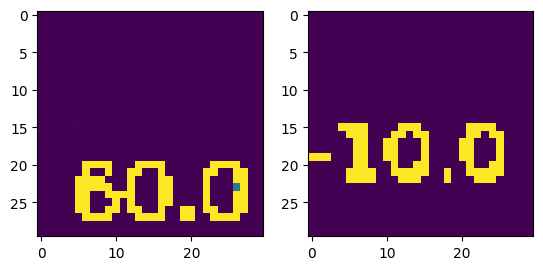

In [2328]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[17][0].numpy())
test_1 = img[17][0].numpy()
ax[1].imshow(croped)
test_2 = croped

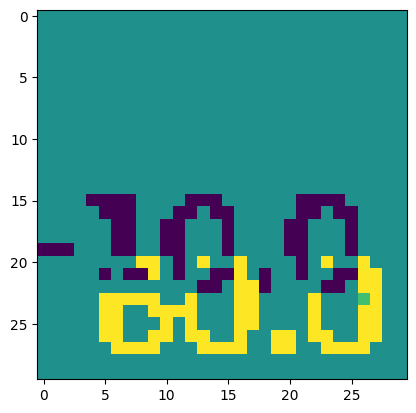

In [2330]:
plt.imshow(test_1 - test_2)